# Strojové učenie

# Zdroje
[Encoding] - https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931

[Stromy] - http://scikit-learn.org/stable/modules/tree.html

# Knižnice

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

import pydotplus
import collections

import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.cross_validation import cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from collections import Counter

from sklearn.tree import export_graphviz
import graphviz


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
#Normalizujeme si kategoricke atributy na cisla
def encodeByNum(data):
    metadata = data.drop(['CLASS'], axis=1)
    columns = metadata.select_dtypes('object').columns
    metadata = pd.get_dummies(metadata, prefix=columns)
    metadata['CLASS'] = data['CLASS']
    return metadata

In [4]:
def init_dataset2(file, sep):
    # Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
    data = pd.read_csv(file, sep=sep, index_col=0)
    
    metadata = data.drop(['DATE_OF_BIRTH', 'CLASS'], axis=1)
    col_names = metadata.select_dtypes('object').columns
    metadata['CLASS'] = data['CLASS']
    
    #print(metadata.info())
    return metadata

In [5]:
def init_dataset(file):
    # Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
    data = pd.read_csv(file, sep=',', index_col=0)
    
    metadata = data.drop(['DATE_OF_BIRTH', 'CLASS'], axis=1)
    col_names = metadata.select_dtypes('object').columns
    metadata['CLASS'] = data['CLASS']
    
    #print(metadata.info())
    return metadata

In [6]:
def getDataSets(train_file, test_file):

    train_data = init_dataset(train_file)
    test_data = init_dataset(test_file)

    #Ziskame si pocet trenovacich dat, aby sme vedeli podla, ktoreho indexu ich neskôr rozdelime
    train_rows_count = train_data.shape[0]

    data = pd.concat([train_data, test_data])
    data.reset_index(drop=True)

    #Transformacia kategorickych na numericke
    data = encodeByNum(data)
    
    #Rozdelenie dat naspat na vstupne datsety
    train_data = data.iloc[:train_rows_count,:]
    test_data = data.iloc[train_rows_count+1:,:]
    
    return train_data, test_data

In [7]:
def getFeaturesLabels(data):
    #Rozdelenie dat na atribúty, ktoré budú trénované na predikovanie triedy
    X = data.drop('CLASS', axis=1)
    y = data['CLASS']
    return X, y

In [8]:
#Zistime si dolezitost atributov
def get_important_features_names(data, clf):
    important_features = []
    for name, importance in zip(data.columns, clf.feature_importances_):
        if importance > 0:
            important_features.append(name)
    return important_features

In [9]:
def prediction(train_X, train_y, test_X, test_y, params):
    #Vytvorime si pipeline s decisionTree clasifikatorom
    pipeline = make_pipeline(SMOTE(random_state=0), DecisionTreeClassifier(**params))
    
    #Vygenerujeme si nove vzorky pre minoritne triedy Algoritmom SMOTE
    x_smote, y_smote = SMOTE().fit_sample(train_X, train_y)
    
    #Natrenujeme si model podľa vyvazenych tried
    pipeline.fit(x_smote, y_smote)
    
    y_pred_train = pipeline.predict(x_smote)
    y_pred_test = pipeline.predict(test_X)
    
    #Otestujeme natrenovaný model na trenovacich datach
    #print(classification_report_imbalanced(y_smote, y_pred_train))
    
    #Otestujeme natrenovaný model na testovacích datach
    #print(classification_report_imbalanced(test_y, y_pred_test))
    
    #Vypiseme si Precision, Recall, Accuracy
    print("Test data Precision: ", precision_score(test_y, y_pred_test, average='macro'))
    print("Train data Precision: ", precision_score(y_smote, y_pred_train, average='macro'))

    print("Test data Recall: ", recall_score(test_y, y_pred_test, average='macro'))
    print("Train data Recall: ", recall_score(y_smote, y_pred_train, average='macro'))

    print("Test data f1_score: ", f1_score(test_y, y_pred_test, average='macro'))
    print("Train data f1_score: ", f1_score(y_smote, y_pred_train, average='macro'))
    
    print("\nVYSLEDKY: (rozdiel medzi predikciou na testovacich a trenovacich)")
    print("Precision rozdiel:", precision_score(y_smote, y_pred_train, average='macro') - precision_score(test_y, y_pred_test, average='macro'))
    print("Recall rozdiel:", recall_score(y_smote, y_pred_train, average='macro') - recall_score(test_y, y_pred_test, average='macro'))
    print("f1_Score rozdiel:", f1_score(y_smote, y_pred_train, average='macro') - f1_score(test_y, y_pred_test, average='macro'))
    return pipeline.steps[1][1]
    

In [10]:
def prediction_random_forest(train_X, train_y, test_X, test_y, params):
    clf = RandomForestClassifier(**params)
    #Natrénujeme model
    clf = clf.fit(train_X, train_y)
    scores = cross_val_score(clf, test_X, test_y, cv=10, scoring="f1_macro")
    
    #Predikujeme triedu pre testovacie dáta
    y_pred_test = clf.predict(test_X)
    y_pred_train = clf.predict(train_X)

    print(confusion_matrix(test_y, y_pred_test))
    print(classification_report(test_y, y_pred_test))
    
    print("Test data Precision: ", precision_score(test_y, y_pred_test, average='macro'))
    print("Train data Precision: ", precision_score(train_y, y_pred_train, average='macro'))

    print("Test data Recall: ", recall_score(test_y, y_pred_test, average='macro'))
    print("Train data Recall: ", recall_score(train_y, y_pred_train, average='macro'))

    print("Test data Accuracy: ", accuracy_score(test_y, y_pred_test))
    print("Train data Accuracy: ", accuracy_score(train_y, y_pred_train))
    
    
    
    print("\nJednotlivé f1_score pre každú iteráciu cross validácie - priemer:")
    print(scores.mean())
    return clf

# Doplnkové čistenie dát
Na zaklade revizie z predosleho odovzdania sme vykonali dodatkove cistenie dat

- Doplnene hodnoty v testovacich datasetoch su doplnene podla hodnot styroch strategii (median, modus, mean, knn) pouzitych z trenovacich datasetov
- Encoding kategorickych atributov

## Výstupné súbory z fáze predspracovania

In [11]:
# file_strategia_dataset
# strategia - {median, modus, mean, knn}.
# Hovori o tom ako boli doplnene chybajuce hodnoty pre numericke atributy vo faze predspracovania

# Trenovacie datasety
file_median_train = 'data/clean_train_data/ctrain_median.csv'
file_modus_train = 'data/clean_train_data/ctrain_modus.csv'
file_mean_train = 'data/clean_train_data/ctrain_mean.csv'
file_knn_train = 'data/clean_train_data/ctrain_knn.csv'

# Testovacie datasety
file_median_test = 'data/clean_test_data/ctest_median.csv'
file_modus_test = 'data/clean_test_data/ctest_modus.csv'
file_mean_test = 'data/clean_test_data/ctest_mean.csv'
file_knn_test = 'data/clean_test_data/ctest_knn.csv'

## Inicializácia DataFramov

In [12]:
# Tejto faze sa vykonava encodovanie kategorickych atributov na numericke

data_median_train, data_median_test = getDataSets(file_median_train, file_median_test)
data_modus_train, data_modus_test = getDataSets(file_modus_train, file_modus_test)
data_mean_train, data_mean_test = getDataSets(file_mean_train, file_mean_test)
data_knn_train, data_knn_test = getDataSets(file_knn_train, file_knn_test)

## Priprava dát na klasifikáciu

In [13]:
# Rozdelenie datasetov pre buduce porovnanie pouzitych strategii
train_median_X, train_median_y = getFeaturesLabels(data_median_train)
test_median_X, test_median_y = getFeaturesLabels(data_median_test)

train_modus_X, train_modus_y = getFeaturesLabels(data_modus_train)
test_modus_X, test_modus_y = getFeaturesLabels(data_modus_test)

train_mean_X, train_mean_y = getFeaturesLabels(data_mean_train)
test_mean_X, test_mean_y = getFeaturesLabels(data_mean_test)

train_knn_X, train_knn_y = getFeaturesLabels(data_knn_train)
test_knn_X, test_knn_y = getFeaturesLabels(data_knn_test)

# Zistujeme najlepsie parametre a atributy pre klasifikaciu

In [14]:
#Vytvoríme Decision tree
clf = DecisionTreeClassifier(random_state=0)
cross_validation = 10 # - násobná crossvalidácia

#Nastavujeme hyperparametre, pre grid search
cv_params = {'class_weight': ['balanced'], 'max_depth': [1,2,3,4] + list(range(5,10,2)), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1,2,3,4]}
optimization = GridSearchCV(clf,
                            cv_params, 
                             scoring = 'f1_macro', cv = cross_validation, n_jobs = -1, verbose=True) 

#Inicializacia grid searchu
optimization_median = GridSearchCV(clf, cv_params, scoring = 'f1_macro', cv = cross_validation, n_jobs = 1, verbose=True) 
optimization_modus = GridSearchCV(clf, cv_params, scoring = 'f1_macro', cv = cross_validation, n_jobs = 1, verbose=True) 
optimization_mean = GridSearchCV(clf, cv_params, scoring = 'f1_macro', cv = cross_validation, n_jobs = 1, verbose=True) 
optimization_knn = GridSearchCV(clf, cv_params, scoring = 'f1_macro', cv = cross_validation, n_jobs = 1, verbose=True) 

### Pouzite parametre pre DecisionTree
<strong>max_depth</strong> - maximálna hĺbka stromu<br>
<strong>criterion</strong> - http://haohanw.blogspot.sk/2014/08/ml-decision-tree-rule-selection.html, The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.<br>
<strong>min_samples_split</strong> - minimálne množstvo vzoriek na rozdelenie prvku v strome<br>
<strong>min_samples_leaf</strong> - minimálne množstvo vzoriek potrebných na jeden list<br>
<strong>class_weight</strong> - nastavenie váhy jednotlivých tried. Chceme aby grid pracoval s vybalancovanymi triedami lebo neskor pouzijeme na natrenovanie modelu SMOTE (over-sampling) na vyvazenie tried

### Pouzite parametre pre GridSearchCV
<strong>scoring</strong> - Kedže máme nevyvážené triedy používame metriku f1_macro<br>

### Pozorovanie
Pri vyskúšaní hyperparametru splitter na random sme zistili, že to nie je správna cesta, pretože nám to veľmi znížilo skóre. Ak sme použili menšie množstvo atribútov (napr. max_features=4), ako 5 (zistlili sme si 5 najlepších parametrov) tak sa na nám skóre výrazne znížili.<br>
Pri znížení násobnosti cross validácie sa nám f1_score znížilo a minimálne sa nám takisto znížili aj pri použití default random state. <br>
Pri použití hyperparametru class_weight a nastavení ho na hodnotu balanced sme zaznamenali pokles skóre.

In [15]:
%%time
# Nájdenie najlepsich parametrov a atributoch pre predikciu podla metriky f1_macro
optimization_median.fit(train_median_X, train_median_y)
optimization_modus.fit(train_modus_X, train_modus_y)
optimization_mean.fit(train_mean_X, train_mean_y)
optimization_knn.fit(train_knn_X, train_knn_y)

Fitting 10 folds for each of 56 candidates, totalling 560 fits


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

Fitting 10 folds for each of 56 candidates, totalling 560 fits


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

Fitting 10 folds for each of 56 candidates, totalling 560 fits


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

Fitting 10 folds for each of 56 candidates, totalling 560 fits


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

CPU times: user 1min 20s, sys: 699 ms, total: 1min 21s
Wall time: 1min 21s


[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:   22.8s finished


In [16]:
#Vypiseme si najlepsie zistene parametre a score pre jednotlive strategie
print('median')
print(optimization_median.best_params_)
print(optimization_median.best_score_)
print('modus')
print(optimization_modus.best_params_)
print(optimization_modus.best_score_)
print('mean')
print(optimization_mean.best_params_)
print(optimization_mean.best_score_)
print('knn')
print(optimization_knn.best_params_)
print(optimization_knn.best_score_)

median
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.809078513139364
modus
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}
0.8502370560413518
mean
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.8767377007729186
knn
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}
0.8563613382101907


In [17]:
# Zistime si, ktoré atributy boli pouzite na natrenovanie modelu z najlepsim skore metrikou f1_macro
best_features_median = get_important_features_names(train_median_X, optimization_median.best_estimator_)
best_features_modus = get_important_features_names(train_modus_X, optimization_modus.best_estimator_)
best_features_mean = get_important_features_names(train_mean_X, optimization_mean.best_estimator_)
best_features_knn = get_important_features_names(train_knn_X, optimization_knn.best_estimator_)

### Model s doplnenými chybajúcimi hodnotami podľa Modus 

In [18]:
# Zistime si najlepsie atributy
best_features = best_features_modus
best_params = optimization_modus.best_params_

# Vypiseme si ake atributy nam grid search odporuca pouzit pri predikcii
print("Best_features: ", best_features)

# Vypiseme si ake parametre nam grid search odporuca pouzit pri predikcii
print("best_params: ", best_params)

#Natrenovanie modelu podla zistených
train_best_data = train_modus_X.loc[:, best_features]
test_best_data = test_modus_X.loc[:, best_features]

#Vykoname predikciu pre parametre a atributy, ktore nam odporuca GridSearch
print("\nPredikcia s parametrami - najlepšie atribúty")
result_modus_best = prediction(train_best_data, train_modus_y, test_best_data, test_modus_y, best_params)

#Vykoname predikciu bez parametrov, a pre vsetky atributy
print("\nPredikcia bez parametrov - všetky atribúty")
result_modus_all = prediction(train_modus_X, train_modus_y, test_modus_X, test_modus_y, {})

Best_features:  ['AGE', 'ON_THYROXINE', 'TSH', 'T3', 'TT4', 'FTI_MEASURED', 'FTI', 'HOURS_PER_WEEK', 'STATE_OTHER', 'RACE_BLACK']
best_params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}

Predikcia s parametrami - najlepšie atribúty
Test data Precision:  0.7908754214204331
Train data Precision:  0.9752807600679988
Test data Recall:  0.8645556204442715
Train data Recall:  0.9742904533726502
Test data f1_score:  0.8240606548577563
Train data f1_score:  0.9742673442284273

VYSLEDKY: (rozdiel medzi predikciou na testovacich a trenovacich)
Precision rozdiel: 0.1844053386475657
Recall rozdiel: 0.10973483292837871
f1_Score rozdiel: 0.15020668937067105

Predikcia bez parametrov - všetky atribúty
Test data Precision:  0.815168363701322
Train data Precision:  1.0
Test data Recall:  0.8276577972698391
Train data Recall:  1.0
Test data f1_score:  0.8203450933947086
Train data f1_score:  1.0

VYSLEDKY: (rozdiel medzi predikciou na testovacich a treno

### Pozorovanie
Môžeme si vsimnut, ze pouzitim odporucanych parametrov a atributov GridSearchom sa nam podarilo zmensit rozdiel Precision, Recall a f1_score pri predikcii na testovacich datach a pri predikcii na trenovacich datach. Tymto sme zabranili pretrenovaniu modelu. Rovnako budeme testovat dalsie strategie

### Model s doplnenými chybajúcimi hodnotami podľa KNN 

In [19]:
# Zistime si najlepsie atributy
best_features = best_features_knn
best_params = optimization_knn.best_params_

print("Best_features: ", best_features)
print("best_params: ", best_params)

#Natrenovanie modelu podla zistených
train_best_data = train_knn_X.loc[:, best_features]
test_best_data = test_knn_X.loc[:, best_features]

print("\nPredikcia s parametrami - najlepšie atribúty")
result_knn_best = prediction(train_best_data, train_knn_y, test_best_data, test_knn_y, best_params)
print("\nPredikcia bez parametrov - všetky atribúty")
result_knn_all = prediction(train_knn_X, train_knn_y, test_knn_X, test_knn_y, {})

Best_features:  ['AGE', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'HOURS_PER_WEEK', 'ON_THYROXINE', 'FTI_MEASURED', 'REFERRAL_SOURCE_SVI']
best_params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}

Predikcia s parametrami - najlepšie atribúty
Test data Precision:  0.7568746167995095
Train data Precision:  0.9764529108713315
Test data Recall:  0.7870757900201155
Train data Recall:  0.9764098783634353
Test data f1_score:  0.7662910173963229
Train data f1_score:  0.9764258999013449

VYSLEDKY: (rozdiel medzi predikciou na testovacich a trenovacich)
Precision rozdiel: 0.21957829407182194
Recall rozdiel: 0.18933408834331977
f1_Score rozdiel: 0.210134882505022

Predikcia bez parametrov - všetky atribúty
Test data Precision:  0.8008779712776494
Train data Precision:  1.0
Test data Recall:  0.8354115216912797
Train data Recall:  1.0
Test data f1_score:  0.8161131966132812
Train data f1_score:  1.0

VYSLEDKY: (rozdiel medzi predikciou na testovacich a tren

### Model s doplnenými chybajúcimi hodnotami podľa Mean 

In [20]:
# Zistime si najlepsie atributy
best_features = best_features_mean
best_params = optimization_mean.best_params_

print("Best_features: ", best_features)
print("best_params: ", best_params)

#Natrenovanie modelu podla zistených
train_best_data = train_mean_X.loc[:, best_features]
test_best_data = test_mean_X.loc[:, best_features]

print("\nPredikcia s parametrami - najlepšie atribúty")
result_mean_best = prediction(train_best_data, train_mean_y, test_best_data, test_mean_y, best_params)
print("\nPredikcia bez parametrov - všetky atribúty")
result_mean_all = prediction(train_mean_X, train_mean_y, test_mean_X, test_mean_y, {})

Best_features:  ['ON_THYROXINE', 'TSH', 'T3', 'TT4', 'FTI_MEASURED', 'FTI', 'HOURS_PER_WEEK']
best_params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}

Predikcia s parametrami - najlepšie atribúty
Test data Precision:  0.7239366620434582
Train data Precision:  0.9720674867235568
Test data Recall:  0.8135152380334394
Train data Recall:  0.9719867305565795
Test data f1_score:  0.7635862942328058
Train data f1_score:  0.9719968926008892

VYSLEDKY: (rozdiel medzi predikciou na testovacich a trenovacich)
Precision rozdiel: 0.24813082468009862
Recall rozdiel: 0.15847149252314008
f1_Score rozdiel: 0.2084105983680834

Predikcia bez parametrov - všetky atribúty
Test data Precision:  0.7883296405378872
Train data Precision:  1.0
Test data Recall:  0.8001476854449521
Train data Recall:  1.0
Test data f1_score:  0.7896245943476481
Train data f1_score:  1.0

VYSLEDKY: (rozdiel medzi predikciou na testovacich a trenovacich)
Precision rozdiel: 0.211670

### Model s doplnenými chybajúcimi hodnotami podľa Median 

In [21]:
# Zistime si najlepsie atributy
best_features = best_features_median
best_params = optimization_median.best_params_

print("Best_features: ", best_features)
print("best_params: ", best_params)

#Natrenovanie modelu podla zistených
train_best_data = train_median_X.loc[:, best_features]
test_best_data = test_median_X.loc[:, best_features]

print("\nPredikcia s parametrami - najlepšie atribúty")
result_median_best = prediction(train_best_data, train_median_y, test_best_data, test_median_y, best_params)
print("\nPredikcia bez parametrov - všetky atribúty")
result_median_all = prediction(train_median_X, train_median_y, test_median_X, test_median_y, {})

Best_features:  ['AGE', 'TSH', 'TT4', 'T4U', 'FTI', 'HOURS_PER_WEEK', 'ON_THYROXINE', 'TSH_MEASURED']
best_params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}

Predikcia s parametrami - najlepšie atribúty
Test data Precision:  0.25188577586206895
Train data Precision:  0.9773104722742931
Test data Recall:  0.26595744680851063
Train data Recall:  0.9769627718392923
Test data f1_score:  0.25441011522381973
Train data f1_score:  0.9769754806074546

VYSLEDKY: (rozdiel medzi predikciou na testovacich a trenovacich)
Precision rozdiel: 0.7254246964122242
Recall rozdiel: 0.7110053250307816
f1_Score rozdiel: 0.7225653653836349

Predikcia bez parametrov - všetky atribúty
Test data Precision:  0.242826780021254
Train data Precision:  1.0
Test data Recall:  0.24308510638297873
Train data Recall:  1.0
Test data f1_score:  0.24295587453482193
Train data f1_score:  1.0

VYSLEDKY: (rozdiel medzi predikciou na testovacich a trenovacich)
Precision rozdiel

Doplnenie medianom sme zistli že nie je najvhodnejšie riešenie, kvôli nízkemu **recall**. Takisto vykazuje aj nanižšiu **správnosť**, takže táto strategia na doplnanie chybajucich hodnot sa nam javí ako najhorsia. 

### Pozorovanie
Stratégia dopĺňania chýbajúcich hodnôt pomocou modus sa zdá byť najvhodnejšia, pretože vykazuje najvyššiu hodnotu Recall. Bola pouzita metrika f1_macro (pretože máme nevyvážené triedy - dominancia  NEGATIVE).

In [22]:
classifiers = pd.DataFrame() # tu sa budu ukladat vysledky jednotlivých klasifikatorov

In [23]:

classifiers = classifiers.append([["DecisionTree", f1_score(train_modus_y, result_modus_best.predict(train_modus_X.loc[:, best_features_modus]), average='macro'), f1_score(test_modus_y, result_modus_best.predict(test_modus_X.loc[:, best_features_modus]),  average='macro')]])


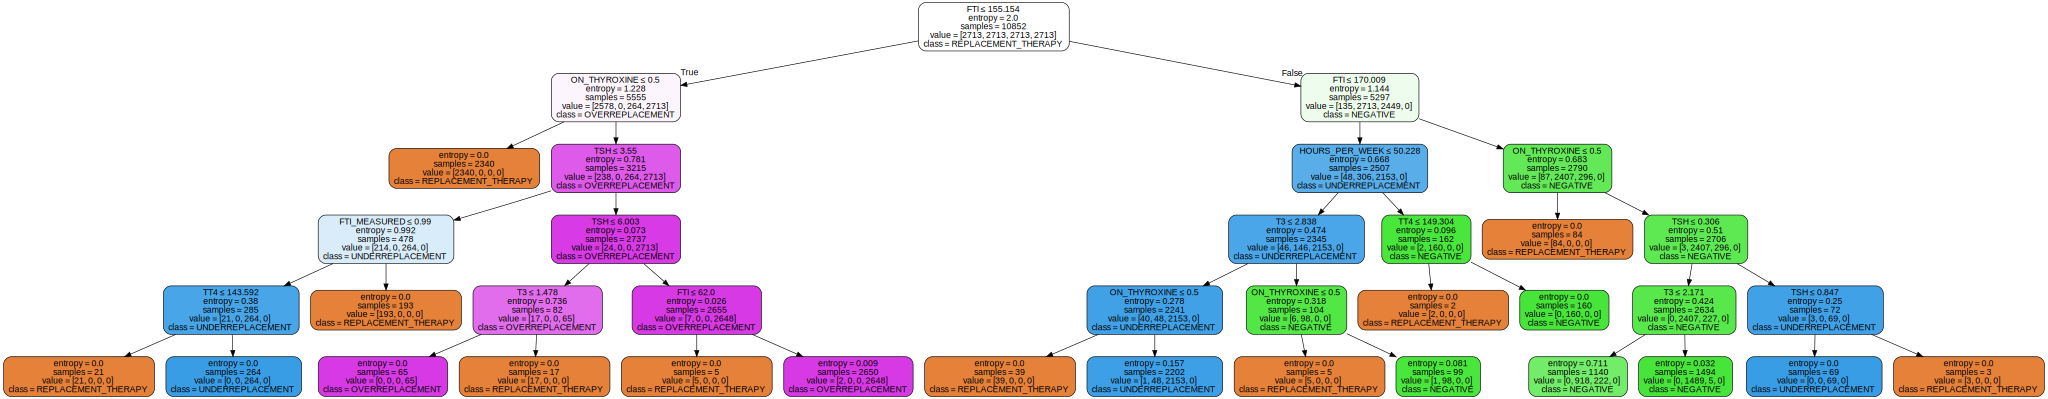

In [26]:
# Kedže podla predchadzajucich pozorovani sme si zvolili model 
dot_data = export_graphviz(result_modus_best, out_file=None, 
                         feature_names=best_features_modus,  
                         class_names=train_modus_y.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("img/tree_best") 
graph
#img = WImage(filename='img/tree_best')
#img

# KNN klasifikátor

In [27]:
train_X = train_modus_X
train_y = train_modus_y

test_X = test_modus_X
test_y = test_modus_y

cls = KNeighborsClassifier(6)
cls.fit(train_X, train_y)
y_pred_train = cls.predict(train_X)
y_pred_test = cls.predict(test_X)
print(cls)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')


In [28]:
print("Predikovanie na trenovacich datach: ",f1_score(train_y, y_pred_train, average='macro'))
print("Predikovanie na testovacich datach: ",f1_score(test_y, y_pred_test, average='macro'))
classifiers = classifiers.append([["KNeighbors", f1_score(train_y, y_pred_train, average='macro'), f1_score(test_y, y_pred_test,  average='macro')]])

Predikovanie na trenovacich datach:  0.2460547796118266
Predikovanie na testovacich datach:  0.24514435695538056


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
print(confusion_matrix(test_y, y_pred_test))
print(classification_report(test_y, y_pred_test))

[[934   0   0   0]
 [ 11   0   0   0]
 [  9   0   0   0]
 [ 17   0   0   0]]
                     precision    recall  f1-score   support

           NEGATIVE       0.96      1.00      0.98       934
    OVERREPLACEMENT       0.00      0.00      0.00        11
REPLACEMENT_THERAPY       0.00      0.00      0.00         9
   UNDERREPLACEMENT       0.00      0.00      0.00        17

        avg / total       0.93      0.96      0.94       971



/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Random Forest Classifier

Zvolili sme nepárny počet stromov, aby jeden bol vždy majoritný.

In [30]:
#Vytvoríme Decision tree
clf = RandomForestClassifier(random_state=0)
cross_validation = 10 # násobná crossvalidácia

#Nastavujeme hyperparametre
cv_params = {'class_weight': ['balanced'], 'n_estimators': list(range(11, 120, 10))}
optimization = GridSearchCV(clf,
                            cv_params, 
                             scoring = 'f1_macro', cv = cross_validation, n_jobs = -1, verbose=True) 

#Inicializacia grid searchu
optimization_median = GridSearchCV(clf, cv_params, scoring = 'f1_macro', cv = cross_validation, n_jobs = -1, verbose=True) 
optimization_modus = GridSearchCV(clf, cv_params, scoring = 'f1_macro', cv = cross_validation, n_jobs = -1, verbose=True) 
optimization_mean = GridSearchCV(clf, cv_params, scoring = 'f1_macro', cv = cross_validation, n_jobs = -1, verbose=True) 
optimization_knn = GridSearchCV(clf, cv_params, scoring = 'f1_macro', cv = cross_validation, n_jobs = -1, verbose=True) 

In [31]:
%%time
optimization_median.fit(train_median_X, train_median_y)
optimization_modus.fit(train_modus_X, train_modus_y)
optimization_mean.fit(train_mean_X, train_mean_y)
optimization_knn.fit(train_knn_X, train_knn_y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   14.4s finished


Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

CPU times: user 2.41 s, sys: 885 ms, total: 3.3 s
Wall time: 54.8 s


[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   13.3s finished


In [32]:
# Zistime si najlepsie atributy
best_features = best_features_modus
best_params = optimization_modus.best_params_

print("Best_features: ", best_features)
print("best_params: ", best_params)
#Natrenovanie modelu podla zistených
train_best_data = train_modus_X.loc[:, best_features]
test_best_data = test_modus_X.loc[:, best_features]

print("\nPredikcia s parametrami - najlepšie atribúty")
result_best = prediction_random_forest(train_best_data, train_modus_y, test_best_data, test_modus_y, best_params)
print("\nPredikcia bez parametrov - všetky atribúty")
result_all = prediction_random_forest(train_modus_X, train_modus_y, test_modus_X, test_modus_y, {})
cls = result_best

Best_features:  ['AGE', 'ON_THYROXINE', 'TSH', 'T3', 'TT4', 'FTI_MEASURED', 'FTI', 'HOURS_PER_WEEK', 'STATE_OTHER', 'RACE_BLACK']
best_params:  {'class_weight': 'balanced', 'n_estimators': 41}

Predikcia s parametrami - najlepšie atribúty


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

[[934   0   0   0]
 [  0  10   1   0]
 [  2   4   3   0]
 [  1   0   0  16]]
                     precision    recall  f1-score   support

           NEGATIVE       1.00      1.00      1.00       934
    OVERREPLACEMENT       0.71      0.91      0.80        11
REPLACEMENT_THERAPY       0.75      0.33      0.46         9
   UNDERREPLACEMENT       1.00      0.94      0.97        17

        avg / total       0.99      0.99      0.99       971

Test data Precision:  0.8652710016770849
Train data Precision:  1.0
Test data Recall:  0.7959001782531194
Train data Recall:  1.0
Test data Accuracy:  0.9917610710607621
Train data Accuracy:  1.0

Jednotlivé f1_score pre každú iteráciu cross validácie - priemer:
0.6649442010450838

Predikcia bez parametrov - všetky atribúty


/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

[[932   0   0   2]
 [  7   2   2   0]
 [  7   1   1   0]
 [ 15   0   0   2]]
                     precision    recall  f1-score   support

           NEGATIVE       0.97      1.00      0.98       934
    OVERREPLACEMENT       0.67      0.18      0.29        11
REPLACEMENT_THERAPY       0.33      0.11      0.17         9
   UNDERREPLACEMENT       0.50      0.12      0.19        17

        avg / total       0.95      0.96      0.95       971

Test data Precision:  0.6174557752341311
Train data Precision:  0.9905197551620869
Test data Recall:  0.35210875603242403
Train data Recall:  0.9395909188263011
Test data Accuracy:  0.964984552008239
Train data Accuracy:  0.9975

Jednotlivé f1_score pre každú iteráciu cross validácie - priemer:
0.287336027016419


In [33]:

classifiers = classifiers.append([["RandomForest", f1_score(train_y, result_best.predict(train_best_data), average='macro'), f1_score(test_y, result_best.predict(test_best_data), average='macro')]])


In [34]:
print(classification_report(test_y, result_best.predict(test_best_data)))

                     precision    recall  f1-score   support

           NEGATIVE       1.00      1.00      1.00       934
    OVERREPLACEMENT       0.71      0.91      0.80        11
REPLACEMENT_THERAPY       0.75      0.33      0.46         9
   UNDERREPLACEMENT       1.00      0.94      0.97        17

        avg / total       0.99      0.99      0.99       971



In [35]:
for est in cls.estimators_:
    dot_data = export_graphviz(est, out_file=None,  
                             class_names=train_y.unique(),  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render("img/random_forest") 

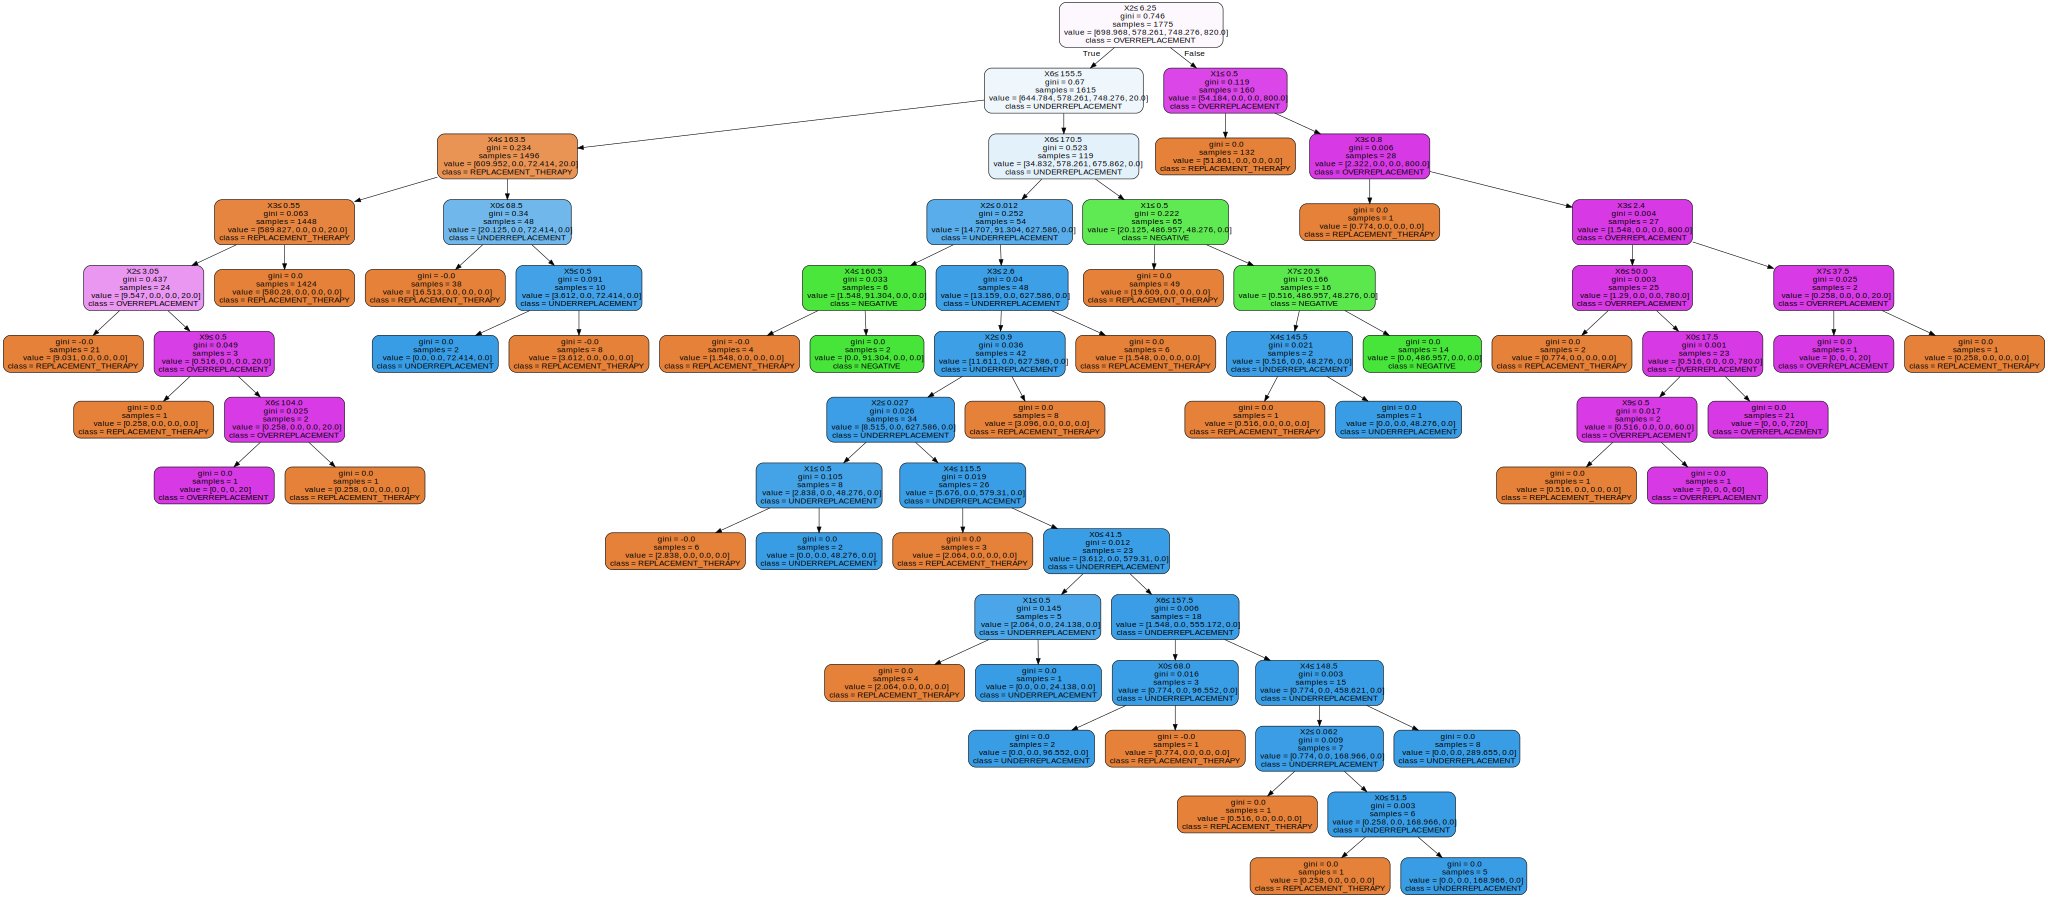

In [36]:
graph

# Porovnanie klasifikátorov

In [37]:
classifiers.columns = ['CLASSIFIER_NAME', 'TRAIN_F1_SCORE', 'TEST_F1_SCORE']
classifiers

,CLASSIFIER_NAME,TRAIN_F1_SCORE,TEST_F1_SCORE
0,DecisionTree,0.955014,0.824061
0,KNeighbors,0.246055,0.245144
0,RandomForest,1.000000,0.807408
